## Introduction

Let $n$ be a positive integer and $S_n$ the symmetric group on $n$ letters. For a partition $\lambda \dashv n$, let $V_\lambda$ denote the irreducible rational representation of $S_n$ corresponding to $\lambda$. For further partitions $\mu, \nu \dashv n$, the Kronecker coefficients $c_{\mu\nu}^\lambda$ are defined by 
$$V_\mu \otimes V_\nu = \bigoplus_{\lambda \dashv n}V_\lambda^{\oplus c_{\mu\nu}^\lambda}$$

One way of computing the Kronecker coefficients is to determine the direct sum decomposition above using the character theory of the symmetric group. The Kronecker coefficients can also be described in terms of the representation theory of the general linear group, and this provides another route for their computation. 

It has long been conjectured that there exists a combinatorial description of the Kronecker coefficients, where $c_{\mu\nu}^\lambda$ can be computed only by reference to the triple $(\mu, \nu, \lambda)$. Such descriptions are currently known only for certain families of triples. We give one example as follows. For a partition $\chi = (\chi_1, \ldots , \chi_k)$ of some $m < n$ with $n-m \geq \chi_1$, write $n(\chi_1, \ldots , \chi_k)$ for the partition $(n-m, \chi_1, \ldots , \chi_k)$ of $n$. Then for any $n \geq 4$ we have 
$$V_{n(1)}\otimes V_{n(1)} = V_{n(0)} \oplus V_{n(1)} \oplus V_{n(2)} \oplus V_{n(1, 1)}
$$

This repository contains a notebook for training a machine learning model that takes as input a triple $(\mu, \nu, \lambda),$ and outputs a prediction for whether or not the coefficient $c^\lambda_{\mu\nu}$ is zero, a slightly easier problem than actually computing the value itself. The plan is that this will fail, because there probably is not a combinatorial formula for computing the Kronecker coefficients in general. 

It's very easy to design a model that fails to learn a prediction task. So this repository will also contain a notebook for training a model to predict the vanishing behaviour of the Littlewood-Richardson coefficients, a similarly-defined collection of numbers for which a combinatorial method of computation is known to exist. Showing that the same model can solve one prediction task but not the other will hopefully convey in some vague way that one of these tasks is more difficult than the other.

Of course, we should already have this vague understanding that one is more difficult because people have spent 80 years trying to find a combinatorial description of the Kronecker coefficients and have failed to do so. And people have already made precise the fact that the Littlewood-Richardson coefficients are 'easier' than the Kronecker coefficients using [a computational complexity argument](https://arxiv.org/abs/1507.02955). And whether or not you can train a model to do something is not a reliable indicator of whether that task is difficult or not. So this is very much a toy project that isn't really suitable for drawing any real conclusions from.

## Littlewood-Richardson coefficients

For positive integers $n, m$ and partitions $\mu \dashv n$, $\nu \dashv m$, the representation $V_\mu \otimes V_\nu$ of $S_n \times S_m$ is irreducible, and all irreducible rational representations of $S_n \times S_m$ are of this form. For $\lambda$ a partition of $n+m$, the representation $V_\lambda$ of $S_{n+m}$ restricts to a representation $V_\lambda\downarrow_{S_n\times S_m}$ of $S_{n}\times S_m$. The Littlewood-Richardson coefficients $b^\lambda_{\mu\nu}$ are defined by 
$$V_\lambda\downarrow_{S_n\times S_m} = \bigoplus_{\mu \dashv n, \nu \dashv m} (V_\mu \otimes V_\nu)^{\oplus b_{\mu\nu}^\lambda}$$

As in the case of the Kronecker coefficients, these coefficients can be computed with knowledge of the relevant character tables of the symmetric groups. Unlike the Kronecker coefficients, there is also a known combinatorial description, [given here](https://en.wikipedia.org/wiki/Littlewood%E2%80%93Richardson_rule#Littlewood%E2%80%93Richardson_tableaux).

## Model architecture

The inspiration for this toy project comes from [a paper that trains a model to generate solutions to differential equations](https://arxiv.org/abs/1912.01412), and we follow their lead in also using a transformer architecture. 

We set the internal dimension to 200, the number of layers to 4, and perform multi-headed attention with 10 heads. I didn't put much thought into this -- this was the first configuration I tried, and since this was sufficient for solving the problem of predicting Littlewood-Richardson coefficients, I didn't experiment further.

The only part of the pipeline unique to this problem is how to represent the input data $(\mu, \nu, \lambda)$.

Since a partition $\mu = (\mu_1, \ldots , \mu_k)$ is simply a tuple of non-negative integers, it makes sense to learn an embedding matrix $A$ that will represent this as a tuple of vectors ($A\mu_1, \ldots , A\mu_k)$. Let $a_i$ denote the vector image of the integer $i$ under this embedding. Then the tuple of vectors is given by $(a_{\mu_1}, \ldots , a_{\mu_k})$.

Since the transformer architecture has no knowledge of the order of the given tuples, we train an additional embedding matrix $B$. With notation as above, for a partition $(\mu_1, \ldots , \mu_k)$, we represent the positional information with the tuple $(b_1, \ldots , b_k)$. This is possibly unnecessary since a partition is determined by the set of its parts anyway, but lots of operations with partitions are made easier by ordering the parts, so we may as well save the model the hassle of keeping track.

Finally, we add further positional information in order to distinguish the three input partitions by training an embedding matrix $C$. 

To give a concrete example, suppose $\mu = (3), \nu = (2, 1)$ and $\lambda = (1, 1, 1)$. The input data will be represented by the tuples of vectors

\begin{align} 
a &= (a_3, a_2, a_1, a_1, a_1, a_1), \\
b &= (b_1, b_1, b_2, b_1, b_2, b_3), \\
c &= (c_1, c_2, c_2, c_3, c_3, c_3)
\end{align}

In order to 'remind' the model of the positional information, we add $b + c$ to the output of each round of attention. 

In order to handle variable input lengths, we pad all inputs to a fixed length and mask appropriately throughout the model. To arrive at a prediction, we take the average of the outputs and apply a sigmoid operator.

## Data

Data is generated using [symchar](https://github.com/benenharrington/symchar). We set the maximum number of parts of a partition to 10, the maximumum part value to 12, and generate a complete set of coefficients satisfying these constraints for all $S_n$ up to $n=15$.

Since the coefficients are symmetric in $\mu$ and $\nu$, and since they appear in various linear relationships with one another, there are plenty of ways information from the training set may 'leak' into the validation set. We attempt to avoid this by associating a tuple $(\mu, \nu, \lambda)$ with the integer $n$ for which $\lambda$ is a partition of, with tuples corresponding to odd $n$ assigned to the validation set. This can be regarded as carving up the data with reference to the underlying symmetric groups.

## Evaluation

There are several ways we might measure performance. Treating each individual coefficient's vanishing behaviour as a prediction task, we could measure the overall accuracy. Random guessing would get 50%. Always guessing the most common label (non-vanishing) would get a score of 75% for the Kronecker problem and 88% for the Littlewood-Richardson problem.

We could also regard a family of preditions as a single prediction task. In the case of the Kronecker coefficients, for any given $(\mu, \nu)$ it would be natural to regard the non-vanishing behaviour of all $c_{\mu\nu}^\lambda$ as a prediction task. Random guessing will give you close to 0% accuracy. Similarly for the Littlewood Richardson coefficients, for each partition $\lambda$ we could regard the non-vanishing behaviour of all $b_{\mu\nu}^\lambda$ as a prediction task.

Going further, we could also use the fact that the validation data is built up of a complete set of data for several different symmetric groups, and score the classifier by individual group performance. 

In order to pursue either of the above two alternatives, we would need to weight the loss function accordingly. For the moment, we'll stick with raw accuracy and see what we can conclude.

For a given accuracy metric, we can also argue how best to measure how quickly it changes as we train the model. For each $\lambda \dashv n$, there are significantly more tuples $(\mu, \nu, \lambda)$ for the Kronecker problem than the Littlewood-Richardson problem, so an epoch for the former is 'longer' than an epoch for the latter. If we compare performance epoch-by-epoch, we might worry that we oversell our performance on the Kronecker problem. On the other hand, the same fact implies that the space to be modelled for the Kronecker problem is larger than that of the Littlewood-Richardson problem, and so comparing performance batch-by-batch will undersell our performance on the Kronecker problem.


Since it turns out that the model learns to predict Littlewood-Richardson coefficients with 100% accuracy, and does not learn to predict Kronecker coefficients with 100% accuracy, any metric we choose will allow us to reach the conclusion we were hoping for. However, the surprisingly strong performane

## Performance

Given all the above, I was hoping that there'd be a very clear distinction between the two, and that however I sliced it there'd be a clear conclusion. 

On one hand, I found that the model reached 100% accuracy for the Littlewood-Richardson problem, and did not for the Kronecker problem, so it does 'better' any way you look at it.

On the other hand, it does really really well on the Kronecker problem, to the point where it looks like it could reach 100% accuracy with some hyperparameter tuning. Which is not what I wanted to see because it takes about 24 hours of p3.xlarge compute to train for 10 epochs.

We first compare epoch-by-epoch for raw accuracy on the validation set, where accuracy at epoch 0 is the best to be had by predicting the most common label:

![](graphs/1.png)

Depending on initial conditions, 100% accuracy is reached for Littlewood-Richardson coefficients within 10-20 epochs, whereas accuracy for Kronecker coefficients fails to improve from around epoch 4. 

This is a lot less satisfying than I was hoping for! I don't think training for another 10 epochs is going to change anything, but I also don't think a single percentage point in accuracy is a great distinction.

Comparing batch-by-batch makes for a more favourable story:

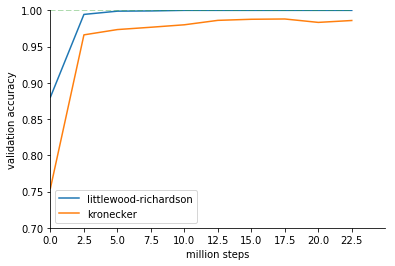

In [9]:
val_data_lr = [0.8804,  0.9944, 0.9989, 0.9992, 1, 1, 1, 1, 1, 1]
val_data_kron = [0.7548, 0.9662, 0.9735, 0.9767, 0.9801, 0.9862, 0.9877, 0.9881, 0.9834, 0.9860]
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot([2.5*i for i in range(0, 10)], val_data_lr, label='littlewood-richardson')
plt.plot([2.5*i for i in range(0, 10)], val_data_kron, label='kronecker')
plt.plot([2.5*i for i in range(0, 10)], [1 for i in range(0, 10)], '--', alpha=0.5)
plt.xticks([2.5*i for i in range(0, 10)])
plt.xlabel('million steps')
plt.ylabel('validation accuracy')
plt.legend()
plt.ylim(0.7, 1.0)
plt.xlim(0, 2.5*10)
plt.show()

If we wanted to give the starkest picture, we could plot the earliest epoch at which each model scores perfect performance on each symmetric group. In the case of the Littlewood-Richardson coefficients, we get the expected behaviour of larger and larger symmetric groups being solved as the model trains. Whereas the model for the Kronecker problem fails to predict the coefficients for a single group correctly.

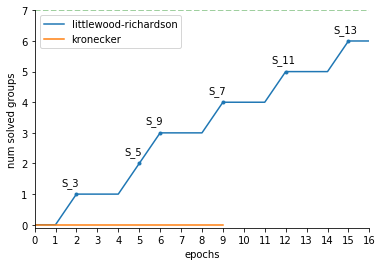

In [105]:
val_data_lr = [0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6]
val_data_kron = [0]*10
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot([i for i in range(0, len(val_data_lr))], val_data_lr, label='littlewood-richardson')
plt.plot([i for i in range(0, 10)], val_data_kron, label='kronecker')
plt.plot([i for i in range(0, len(val_data_lr))], [7 for i in range(0, len(val_data_lr))], '--', color='green', alpha=0.5)
plt.plot([2, 5, 6, 9, 12, 15], [i for i in range(1, 7)], 'o', color='C0', markersize=3)
plt.xticks([i for i in range(0, len(val_data_lr))])
plt.xlabel('epochs')
plt.ylabel('num solved groups')
plt.legend()
plt.annotate('S_3', [1.3,1.3])
plt.annotate('S_5', [4.3,2.3])
plt.annotate('S_9', [5.3,3.3])
plt.annotate('S_7', [8.3,4.3])
plt.annotate('S_11', [11.3,5.3])
plt.annotate('S_13', [14.3,6.3])
plt.ylim(-0.1, 7.0)
plt.xlim(0, len(val_data_lr)-1)
plt.show()

Again, there are more coefficients to predict for any given group in the case of the Kronecker problem, so at an equal level of accuracy it's not necessarily surprising that more groups would be solved at for the Littlewood-Richardson problem. 

But looking at individual group accuracy as the model trains shows that this is not what's going on here:

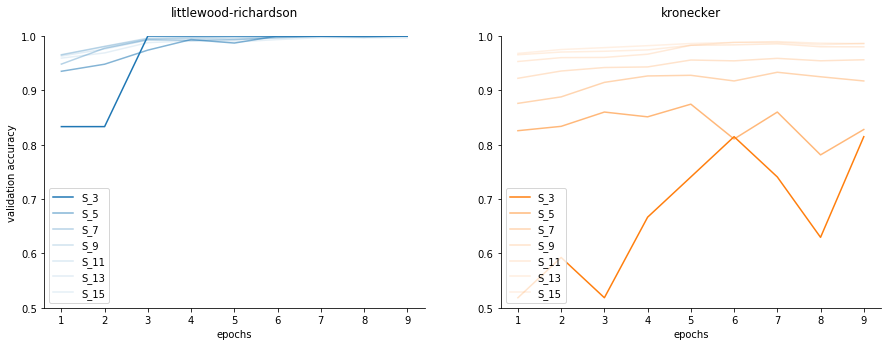

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)
s3_lr = [0.8333, 0.8333, 1, 1, 1, 1, 1, 1, 1, 1]
s5_lr = [0.9351, 0.9481, 0.9740, 0.9935, 0.9870, 1, 1, 1, 1, 1]
s7_lr = [0.9483, 0.9775, 0.9933, 0.9917, 0.9933, 0.9967, 0.9992, 0.9975, 1, 0.9992]
s9_lr = [0.9656, 0.9810, 0.9960, 0.9965, 0.9972, 0.9983, 1, 0.9997, 0.9999, 0.9994]
s11_lr = [0.9651, 0.9805, 0.9946, 0.9974, 0.9953, 0.9985, 0.9995, 0.9993, 0.9995, 0.9995]
s13_lr = [0.9631, 0.9761, 0.9924, 0.9949, 0.9927, 0.9969, 0.9989, 0.9988, 0.9989, 0.9994]
s15_lr = [0.9593, 0.9689, 0.9878, 0.9911, 0.9890, 0.9934, 0.9970, 0.9966, 0.9965, 0.9979]
s3_kron = [0.5185, 0.5926, 0.5185, 0.6667, 0.7407, 0.8148, 0.7407, 0.6296, 0.8148]
s5_kron = [0.8258, 0.8338, 0.8601, 0.8513, 0.8746, 0.8105, 0.8601, 0.7813, 0.8280]
s7_kron = [0.8761, 0.8880, 0.9147, 0.9265, 0.9277, 0.9173, 0.9333, 0.9250, 0.9173]
s9_kron = [0.9222, 0.9356, 0.9420, 0.9431, 0.9558, 0.9543, 0.9589, 0.9544, 0.9563]
s11_kron = [0.9531, 0.9602, 0.9606, 0.9665, 0.9829, 0.9837, 0.9856, 0.9802, 0.9801]
s13_kron = [0.9655, 0.9705, 0.9719, 0.9744, 0.9829, 0.9883, 0.9897, 0.9867, 0.9859]
s15_kron = [0.9680, 0.9751, 0.9786, 0.9822, 0.9862, 0.9881, 0.9881, 0.9839, 0.9865]
for j, lr in enumerate([s3_lr, s5_lr, s7_lr, s9_lr, s11_lr, s13_lr, s15_lr]):
    axs[0].plot([i+1 for i in range(0, len(lr[:-1]))], lr[:-1], color='C0', label=f"S_{2*j+3}", alpha=(0.9*(0.5)**j)+0.1)
for j, kron in enumerate([s3_kron, s5_kron, s7_kron, s9_kron, s11_kron, s13_kron, s15_kron]):
    axs[1].plot([i+1 for i in range(0, len(kron))], kron, color='C1', label=f"S_{2*j+3}", alpha=(0.9*(0.5)**j)+0.1)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[0].set_ylabel('validation accuracy')
axs[0].set_title('littlewood-richardson')
axs[1].set_title('kronecker')
axs[0].set_xlabel('epochs')
axs[1].set_xlabel('epochs')
axs[0].set_ylim(0.5, 1)
axs[1].set_ylim(0.5, 1)
axs[0].legend(loc=3)
axs[1].legend(loc=3)
ttl = axs[0].title
ttl.set_position([.5, 1.05])
ttl = axs[1].title
ttl.set_position([.5, 1.05])

In the case of the Littlewood-Richardson coefficients, performance within each group closely tracks overall performance, and steadily increases as the model trains. Whereas for the Kronecker coefficients, performance trends upwards only for the larger symmetric groups.

One possible way of explaining this is that in the case of the Littlewood-Richardson coefficients, the model is learning in a way that's invariant in to the size of the group. And one such example of what this might look like is given by the case $\mu = \nu = n(1)$ described in the introduction, where $c_{\mu\nu}^\lambda$ can be computed without thinking much about $n$ itself. 

Whereas in the case of the Kronecker coefficients, the model learns to exploit heuristics that are useful for large $n$, but still don't give the full story. An example of such a heuristic is would be recognising that when $\mu$ and $\nu$ are 'blocky', the corresponding representations have high-dimension, and so for any given $\lambda$, the probability that $c_{\mu\nu}^\lambda$ is non-zero is high. I need to do some work to figure out if this is actually happening.